In [25]:
import ray

In [26]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2025-09-04 15:33:40,877	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.12
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [27]:
ray.cluster_resources()

{'node:172.27.14.77': 1.0,
 'GPU': 1.0,
 'accelerator_type:RTX': 1.0,
 'object_store_memory': 200000000000.0,
 'CPU': 96.0,
 'memory': 863542656000.0,
 'node:__internal_head__': 1.0}

In [28]:
import pandas as pd

In [29]:
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)

In [30]:
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [31]:
df.shape

(764, 5)

In [32]:
df.tag.value_counts(normalize=True)

tag
natural-language-processing    0.405759
computer-vision                0.373037
other                          0.138743
mlops                          0.082461
Name: proportion, dtype: float64

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
test_size = 0.2
train_df, val_df = train_test_split(df, test_size=test_size, stratify=df.tag, random_state=1234)

In [35]:
val_df.tag.value_counts(normalize=True)

tag
natural-language-processing    0.405229
computer-vision                0.372549
other                          0.137255
mlops                          0.084967
Name: proportion, dtype: float64

## EDA

In [36]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS

In [39]:
sns.set_theme()
warnings.filterwarnings("ignore")

In [38]:
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

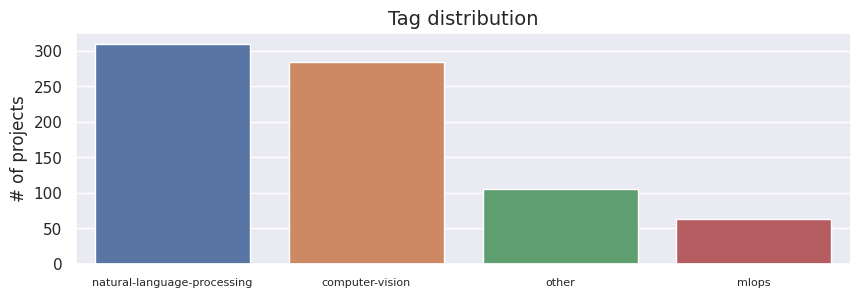

In [41]:
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

### Word frequency per tag

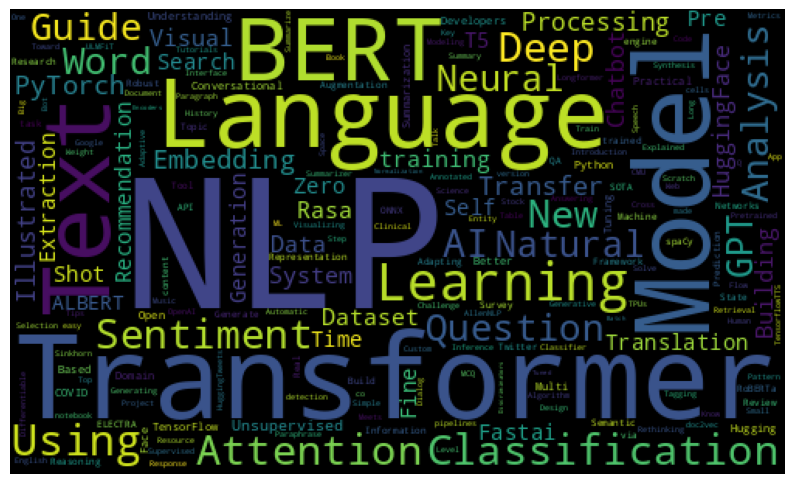

In [46]:
tag="natural-language-processing"
plt.figure(figsize=(10, 7))
subset = df[df.tag == tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300
).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

## Data Preprocessing

In [47]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [48]:
df['text'] = df['title'] + ' ' + df['description']

In [49]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /work/ngkuissi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [50]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    text = text.lower()
    
    # remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)
    
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text
    

In [51]:
original_df = df.copy()
df.text = df.text.apply(clean_text)

In [55]:
print("Original text:", original_df.text.values[1])
print("Processed text:", df.text.values[1])

Original text: Show, Infer & Tell: Contextual Inference for Creative Captioning The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.

Processed text: show infer tell contextual inference creative captioning beauty work lies way architects fundamental idea humans look overall image individual pieces


In [56]:
df.columns

Index(['id', 'created_on', 'title', 'description', 'tag', 'text'], dtype='object')

In [57]:
df = df.drop(columns=['id', 'created_on', 'title', 'decription'], errors='ignore')
df = df.dropna(subset='tag')
df = df[['text', 'tag']]
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [61]:
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_idx = {tag: i for i, tag in enumerate(tags)}

In [62]:
class_to_idx

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [63]:
df['tag'] = df['tag'].map(class_to_idx)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3
